# Predicting Housing Prices

The goal of this notebook is to try and predict the SalesPrice of homes in Ames, Iowa. As per the Kaggle rules this will require some **feature engineering** as well as the usage of **Random Forest** models.

The approach I will take is as follows:
1. Import the data
2. Identify any strong correlations in the data
3. Determine if there are missing values
4. Remove features that are mostly null
5. Impute remaining features with mean data (numerical) and most frequent data (categorical)
6. Scale the data if needed


The kaggle competition page can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

**Key Things to Use**
1. Random Forest
2. Cross Validation
3. Feature Engineering

## Import all the goodies

In [218]:
# data handling and prediction
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals.six import StringIO
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy import stats


#visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
import pydotplus

In [219]:
housing_data_train = pd.read_csv("../data/train.csv",na_values='NA')
housing_data_test = pd.read_csv("../data/test.csv",na_values='NA') #does not contain Saleprice column which is what we predict
# Convert the headers to lowercase
housing_data_train.columns = map(str.lower, housing_data_train.columns)
housing_data_test.columns = map(str.lower, housing_data_test.columns)

## Let's do some exploration

In [220]:
housing_data_train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Lets take a look at the stats for the numerical data**

In [221]:
housing_data_train.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [222]:
print housing_data_train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64


## Correlation
Lets take a look at the correlation of the features to see if we can identify the important ones

In [223]:
housing_data_train.corr()["saleprice"].sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
1stflrsf         0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
2ndflrsf         0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
3ssnporch        0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
id              -0.021917
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: salepr

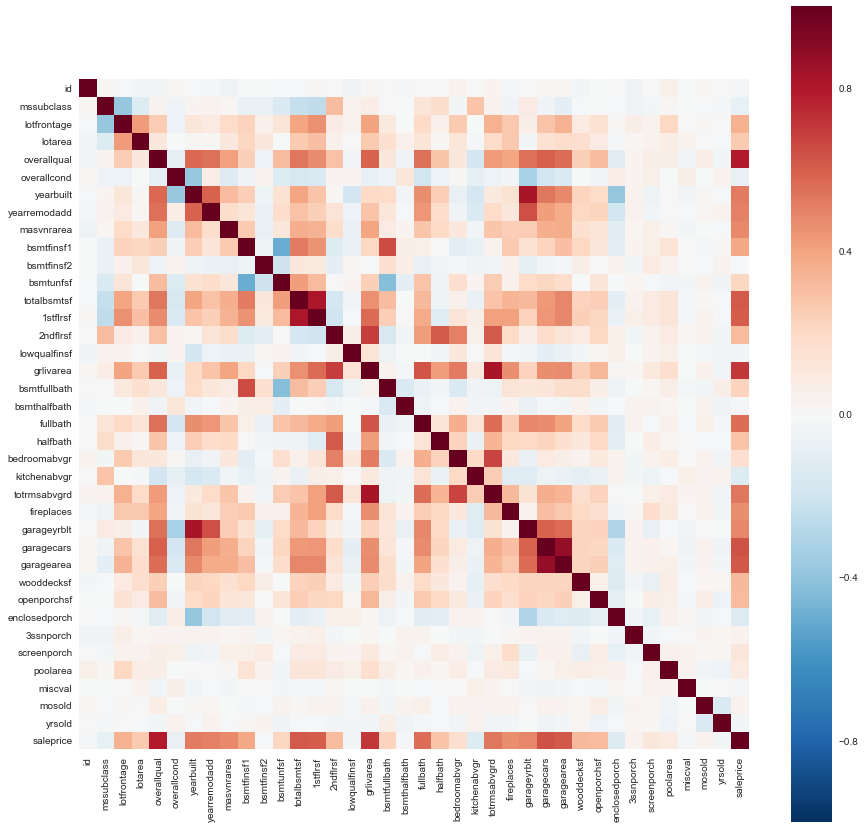

In [224]:
housing_corr = housing_data_train.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(housing_corr, square=True)

Let's select the fields with a correlation of .4 or higher and see how the relationship to SalePrice looks.

In [225]:
important_features = ['overallqual','grlivarea','garagecars','garagearea','totalbsmtsf',
                      '1stflrsf','fullbath','totrmsabvgrd','yearbuilt','yearremodadd',
                      'garageyrblt','masvnrarea','fireplaces','saleprice']


## Split Numeric and Categorical Data

In [226]:
housing_data_train_numeric = housing_data_train.select_dtypes(include=['int64','float64'])

In [227]:
#housing_data_train_numeric = housing_data_train_numeric.drop('saleprice',axis=1)

In [228]:
housing_data_train_categories = housing_data_train.select_dtypes(exclude=['int64','float64'])

## Impute Missing Data

In [229]:
percent_null = (housing_data_train_categories.isnull().sum())

percent_null.sort_values(ascending=False)

poolqc           1453
miscfeature      1406
alley            1369
fence            1179
fireplacequ       690
garagecond         81
garagequal         81
garagefinish       81
garagetype         81
bsmtfintype2       38
bsmtexposure       38
bsmtfintype1       37
bsmtqual           37
bsmtcond           37
masvnrtype          8
electrical          1
condition2          0
condition1          0
neighborhood        0
landslope           0
bldgtype            0
landcontour         0
lotconfig           0
utilities           0
roofstyle           0
lotshape            0
street              0
housestyle          0
salecondition       0
roofmatl            0
exterior1st         0
exterior2nd         0
exterqual           0
extercond           0
foundation          0
saletype            0
heating             0
heatingqc           0
centralair          0
kitchenqual         0
functional          0
paveddrive          0
mszoning            0
dtype: int64

Since some of our features are missing a large percentage of their data we will just drop them.

In [230]:
drop_columns = ['alley','poolqc','fence','miscfeature', 'fireplacequ','garagetype','garagefinish',
               'garagequal','garagecond']
for column in drop_columns:
    housing_data_train_categories = housing_data_train_categories.drop(column, axis=1)

Now let's check the null data in the numeric features.

In [231]:
numeric_percent_null = housing_data_train_numeric.isnull().sum()
numeric_percent_null.sort_values(ascending=False)

lotfrontage      259
garageyrblt       81
masvnrarea         8
bsmtfinsf1         0
lowqualfinsf       0
2ndflrsf           0
1stflrsf           0
totalbsmtsf        0
bsmtunfsf          0
bsmtfinsf2         0
saleprice          0
bsmtfullbath       0
yearremodadd       0
yearbuilt          0
overallcond        0
overallqual        0
lotarea            0
mssubclass         0
grlivarea          0
bsmthalfbath       0
yrsold             0
fullbath           0
mosold             0
miscval            0
poolarea           0
screenporch        0
3ssnporch          0
enclosedporch      0
openporchsf        0
wooddecksf         0
garagearea         0
garagecars         0
fireplaces         0
totrmsabvgrd       0
kitchenabvgr       0
bedroomabvgr       0
halfbath           0
id                 0
dtype: int64

Since lot frontage is missing over 17% of the data I will just drop it.

In [232]:
housing_data_train_numeric = housing_data_train_numeric.drop(['lotfrontage','garageyrblt'], axis=1)

## Impute numeric data with the mean value

In [233]:
mean_per_column = housing_data_train_numeric.apply(lambda x: x.mean(),axis=0)
numeric_mean_filled = housing_data_train_numeric.fillna(mean_per_column,axis=0)
numeric_mean_filled.isnull().sum()

id               0
mssubclass       0
lotarea          0
overallqual      0
overallcond      0
yearbuilt        0
yearremodadd     0
masvnrarea       0
bsmtfinsf1       0
bsmtfinsf2       0
bsmtunfsf        0
totalbsmtsf      0
1stflrsf         0
2ndflrsf         0
lowqualfinsf     0
grlivarea        0
bsmtfullbath     0
bsmthalfbath     0
fullbath         0
halfbath         0
bedroomabvgr     0
kitchenabvgr     0
totrmsabvgrd     0
fireplaces       0
garagecars       0
garagearea       0
wooddecksf       0
openporchsf      0
enclosedporch    0
3ssnporch        0
screenporch      0
poolarea         0
miscval          0
mosold           0
yrsold           0
saleprice        0
dtype: int64

In [234]:
housing_data_train_categories.describe()

,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,bsmtfintype2,heating,heatingqc,centralair,electrical,kitchenqual,functional,paveddrive,saletype,salecondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1422,1460,1460,1460,1459,1460,1460,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,...,6,6,5,2,5,4,7,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,...,1256,1428,741,1365,1334,735,1360,1340,1267,1198


## Impute numeric data with median value (may not need)

In [235]:
#median_per_column = housing_data_train_numeric.apply(lambda x: x.mean(),axis=0)
#numeric_median_filled = housing_data_train_numeric.fillna(median_per_column,axis=0)

## Impute categorical data with most frequent value

In [236]:
def get_most_frequent_value (column):
    return column.value_counts().index[0]

most_frequent_values = housing_data_train_categories.apply(get_most_frequent_value,axis=0)

In [237]:
most_frequent_values = housing_data_train_categories.apply(get_most_frequent_value,axis=0)
#print("Most frequent value in each column:\n"),most_frequent_values

In [238]:
categorical_most_frequent = housing_data_train_categories.fillna(most_frequent_values,axis=0)

In [239]:
categorical_most_frequent.isnull().sum()

mszoning         0
street           0
lotshape         0
landcontour      0
utilities        0
lotconfig        0
landslope        0
neighborhood     0
condition1       0
condition2       0
bldgtype         0
housestyle       0
roofstyle        0
roofmatl         0
exterior1st      0
exterior2nd      0
masvnrtype       0
exterqual        0
extercond        0
foundation       0
bsmtqual         0
bsmtcond         0
bsmtexposure     0
bsmtfintype1     0
bsmtfintype2     0
heating          0
heatingqc        0
centralair       0
electrical       0
kitchenqual      0
functional       0
paveddrive       0
saletype         0
salecondition    0
dtype: int64

## Exploring the Categorical Data

In [240]:
for column in categorical_most_frequent:
    print categorical_most_frequent[column].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: mszoning, dtype: int64
Pave    1454
Grvl       6
Name: street, dtype: int64
Reg    925
IR1    484
IR2     41
IR3     10
Name: lotshape, dtype: int64
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: landcontour, dtype: int64
AllPub    1459
NoSeWa       1
Name: utilities, dtype: int64
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: lotconfig, dtype: int64
Gtl    1382
Mod      65
Sev      13
Name: landslope, dtype: int64
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: neighborhood, dtype: int64
Norm      1260
Feedr       81
Artery     

In [241]:
#doing the same thing for specific columns
#cat_to_num_list = ['exterior2nd','utilities','housestyle','heating','exterior1st','roofmatl',
#                  'condition2','electrical','garagequal']
#for column in cat_to_num_list:
#    print categorical_most_frequent[column].value_counts()

**Transform the categorical fields using get_dummies function**

In [242]:
categorical_list = categorical_most_frequent.columns.tolist()
housing_dummies = pd.get_dummies(categorical_most_frequent,columns=categorical_list)
housing_dummies.head()

,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Grvl,street_Pave,lotshape_IR1,lotshape_IR2,lotshape_IR3,...,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0


## Try label encoder instead

In [243]:
housing_labels = categorical_most_frequent.apply(LabelEncoder().fit_transform)

In [244]:
housing_labels.head()

,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,bsmtfintype2,heating,heatingqc,centralair,electrical,kitchenqual,functional,paveddrive,saletype,salecondition
0,3,1,3,3,0,4,0,5,2,2,...,5,1,0,1,4,2,6,2,8,4
1,3,1,3,3,0,2,0,24,1,2,...,5,1,0,1,4,3,6,2,8,4
2,3,1,0,3,0,4,0,5,2,2,...,5,1,0,1,4,2,6,2,8,4
3,3,1,0,3,0,0,0,6,2,2,...,5,1,2,1,4,2,6,2,8,0
4,3,1,0,3,0,2,0,15,2,2,...,5,1,0,1,4,2,6,2,8,4


## Adjust the skew of the data
Here I am going to adjust the skew of all of the important numerical features including the Sale Price

In [245]:
#numeric_features = numeric_mean_filled[important_features]
# Let's add a very small number to the dataset so that we do not run into any errors and using the log function
# numeric_features += .000001


Let's check the features that need to be transformed

In [246]:
#all_skews = numeric_features.apply(stats.skew, axis=0)
#all_skews

We are going to transform only the skews with an absolute value greater than .5

In [247]:
#skews_to_transform = all_skews[all_skews.abs()>0.5]
#skew_columns = skews_to_transform.index.tolist()

In [248]:
#skew_columns

In [249]:
#skew_transformed_columns = numeric_features[skew_columns].apply(np.log)
#transformed_numeric = pd.concat([numeric_features[numeric_features.columns[~numeric_features.columns.isin(skew_columns)]],
                                #skew_transformed_columns],axis=1)

In [250]:
# May need to drop the ID column
#numeric_with_id = numeric_mean_filled.id
#numeric_mean_filled = numeric_mean_filled.drop('id',axis=1)

Now let's check a few of the distributions

In [251]:
#sns.distplot(transformed_features.saleprice)

### Join the datasets back together

In [252]:
all_housing_data = numeric_mean_filled.merge(housing_dummies, left_index=True,
                                            right_index=True)

In [253]:
housing_X_labels = numeric_mean_filled.merge(housing_labels, left_index=True,
                                            right_index=True)

In [254]:
housing_X_labels = housing_X_labels.drop('saleprice',axis=1)

In [255]:
housing_X = all_housing_data.copy()

In [256]:
housing_y = housing_data_train_numeric.saleprice

In [257]:
housing_X = housing_X.drop("saleprice",axis=1)

In [258]:
housing_X_254 = housing_X.copy()

In [259]:
diff_list = ['exterior2nd_Other',
 'utilities_NoSeWa',
 'housestyle_2.5Fin',
 'heating_Floor',
 'exterior1st_Stone',
 'roofmatl_ClyTile',
 'roofmatl_Roll',
 'condition2_RRAe',
 'condition2_RRNn',
 'heating_OthW',
 'roofmatl_Membran',
 'condition2_RRAn',
 'roofmatl_Metal',
 'electrical_Mix',
 'exterior1st_ImStucc']

for column in diff_list:
    housing_X_254 = housing_X_254.drop(column, axis=1)

## Training the Model

In [260]:
rf = RandomForestRegressor(n_estimators=50, random_state=123)
cross_val_scores = cross_val_score(rf,housing_X,housing_y,cv=10)
print "10-fold accuracies:\n",cross_val_scores
print "Mean cv-accuracy:",np.mean(cross_val_scores)
print "Std of cv-accuracy:",np.std(cross_val_scores)

10-fold accuracies:
[ 0.86244726  0.89025857  0.91848791  0.7694164   0.89023032  0.89007598
  0.89000209  0.88749175  0.78651475  0.85120081]
Mean cv-accuracy: 0.863612583147
Std of cv-accuracy: 0.0462267807821


## Trying Grid Search

In [261]:
rf_grid = RandomForestRegressor(n_estimators=50,random_state=123,n_jobs=-1)
max_depth_range = range(1,25)
min_leaf_range = range(1,2)
param_grid = dict(max_depth=max_depth_range,min_samples_leaf = min_leaf_range)
grid = GridSearchCV(rf_grid,param_grid, cv=10, scoring='r2')
grid.fit(housing_X, housing_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'min_samples_leaf': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [262]:
print grid.best_score_
print grid.best_params_
print grid.best_estimator_
#print grid.cv_results_['mean_test_score']
#grid_mean_scores = grid.cv_results_['mean_test_score']
#print grid_mean_scores

0.86579049217
{'max_depth': 13, 'min_samples_leaf': 1}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)


In [263]:
rf_grid = RandomForestRegressor(n_estimators=50,random_state=123,n_jobs=-1,max_depth=20, min_samples_leaf=1)
rf_grid.fit(housing_X,housing_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)

In [264]:
print "R-Squared:",np.sqrt(mean_squared_error(housing_y, rf_grid.predict(housing_X)))

R-Squared: 11000.4136497


There was no difference between scaling and not scaling the data.

In [265]:
housing_X_pred = housing_X.copy()
housing_X_pred = pd.concat((housing_X_pred,housing_y),axis=1)
housing_X_pred['pred_saleprice'] = rf_grid.predict(housing_X).astype('int')
#housing_X_pred['pred_saleprice'] = housing_X_pred['pred_saleprice'].apply(pd.to_numeric)

In [266]:
price_columns = ['id','saleprice','pred_saleprice']
housing_X_pred[price_columns].head()


,id,saleprice,pred_saleprice
0,1,208500,204405
1,2,181500,176353
2,3,223500,221251
3,4,140000,156923
4,5,250000,262574


That does not seem too bad to me.

## Grid Search with dropped categorical variables

In [267]:
rf_grid2 = RandomForestRegressor(n_estimators=50,random_state=123,n_jobs=-1)
max_depth_range = range(1,25)
min_leaf_range = range(1,2)
param_grid = dict(max_depth=max_depth_range,min_samples_leaf = min_leaf_range)
grid2 = GridSearchCV(rf_grid,param_grid, cv=10, scoring='r2')
grid2.fit(housing_X_254, housing_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'min_samples_leaf': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [268]:
print grid2.best_score_
print grid2.best_params_
print grid2.best_estimator_
#print grid.cv_results_['mean_test_score']
#grid_mean_scores = grid.cv_results_['mean_test_score']
#print grid_mean_scores

0.864976317093
{'max_depth': 17, 'min_samples_leaf': 1}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)


In [269]:
rf_grid2 = RandomForestRegressor(n_estimators=50,random_state=123,n_jobs=-1,max_depth=20, min_samples_leaf=1)
rf_grid2.fit(housing_X_254,housing_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)

In [270]:
print "RMSE:",np.sqrt(mean_squared_error(housing_y, rf_grid2.predict(housing_X_254)))

RMSE: 10692.9183678


## Grid Search with Label Encoded Categorical Variables

In [271]:
rf_grid3 = RandomForestRegressor(n_estimators=50,random_state=123,n_jobs=-1)
max_depth_range = range(1,25)
min_leaf_range = range(1,2)
param_grid = dict(max_depth=max_depth_range,min_samples_leaf = min_leaf_range)
grid3 = GridSearchCV(rf_grid,param_grid, cv=10, scoring='r2')
grid3.fit(housing_X_labels, housing_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'min_samples_leaf': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [272]:
print grid3.best_score_
print grid3.best_params_
print grid3.best_estimator_
#print grid.cv_results_['mean_test_score']
#grid_mean_scores = grid.cv_results_['mean_test_score']
#print grid_mean_scores

0.867449416081
{'max_depth': 13, 'min_samples_leaf': 1}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)


In [273]:
rf_grid3 = RandomForestRegressor(n_estimators=50,random_state=123,n_jobs=-1,max_depth=20, min_samples_leaf=1)
rf_grid3.fit(housing_X_labels,housing_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)

In [274]:
print "RMSE:",np.sqrt(mean_squared_error(housing_y, rf_grid3.predict(housing_X_labels)))

RMSE: 10659.6926982


## Feature Importance

In [91]:
#pd.DataFrame({'feature':housing_X.columns.tolist(),
 #             'importance':rf_grid.feature_importances_}) 

## DOING ALL OF THIS AGAIN TO THE TRAINING SET

In [203]:
housing_data_test_numeric = housing_data_test.select_dtypes(include=['int64','float64'])
housing_data_test_categories = housing_data_test.select_dtypes(exclude=['int64','float64'])

In [204]:
percent_null = (housing_data_test_categories.isnull().sum()/
                housing_data_test.isnull().count())
percent_null.sort_values(ascending=False)

poolqc           0.997944
miscfeature      0.965045
alley            0.926662
fence            0.801234
fireplacequ      0.500343
garagecond       0.053461
garagefinish     0.053461
garagequal       0.053461
garagetype       0.052090
bsmtcond         0.030843
bsmtexposure     0.030158
bsmtqual         0.030158
bsmtfintype1     0.028787
bsmtfintype2     0.028787
masvnrtype       0.010966
mszoning         0.002742
utilities        0.001371
functional       0.001371
exterior1st      0.000685
saletype         0.000685
exterior2nd      0.000685
kitchenqual      0.000685
condition1       0.000000
condition2       0.000000
electrical       0.000000
extercond        0.000000
bldgtype         0.000000
centralair       0.000000
neighborhood     0.000000
exterqual        0.000000
                   ...   
bsmthalfbath          NaN
bsmtunfsf             NaN
enclosedporch         NaN
fireplaces            NaN
fullbath              NaN
garagearea            NaN
garagecars            NaN
garageyrblt 

In [205]:
numeric_percent_null = (housing_data_test_numeric.isnull().sum()/
                        housing_data_test_numeric.isnull().count())
numeric_percent_null.sort_values(ascending=False)

lotfrontage      0.155586
garageyrblt      0.053461
masvnrarea       0.010281
bsmthalfbath     0.001371
bsmtfullbath     0.001371
garagearea       0.000685
bsmtfinsf1       0.000685
bsmtfinsf2       0.000685
bsmtunfsf        0.000685
totalbsmtsf      0.000685
garagecars       0.000685
overallqual      0.000000
overallcond      0.000000
yearbuilt        0.000000
yearremodadd     0.000000
lowqualfinsf     0.000000
lotarea          0.000000
mssubclass       0.000000
1stflrsf         0.000000
2ndflrsf         0.000000
yrsold           0.000000
grlivarea        0.000000
mosold           0.000000
fullbath         0.000000
halfbath         0.000000
bedroomabvgr     0.000000
kitchenabvgr     0.000000
totrmsabvgrd     0.000000
fireplaces       0.000000
wooddecksf       0.000000
openporchsf      0.000000
enclosedporch    0.000000
3ssnporch        0.000000
screenporch      0.000000
poolarea         0.000000
miscval          0.000000
id               0.000000
dtype: float64

In [217]:
category_drop = ['alley','poolqc','fence','miscfeature', 'fireplacequ','garagetype','garagefinish',
               'garagequal','garagecond']
for column in category_drop:
    housing_data_test_categories = housing_data_test_categories.drop(column, axis=1)

ValueError: labels ['alley'] not contained in axis

In [207]:
housing_data_test_numeric = housing_data_test_numeric.drop('lotfrontage', axis=1)

In [208]:
test_mean_per_column = housing_data_test_numeric.apply(lambda x: x.mean(),axis=0)
test_mean_filled = housing_data_test_numeric.fillna(test_mean_per_column,axis=0)

In [209]:
test_most_frequent_values = housing_data_test_categories.apply(get_most_frequent_value,axis=0)
test_most_frequent = housing_data_test_categories.fillna(test_most_frequent_values,axis=0)

In [210]:
test_categorical_list = test_most_frequent.columns.tolist()
test_housing_dummies = pd.get_dummies(test_most_frequent,columns=test_categorical_list)
test_housing_dummies.head()

,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Grvl,street_Pave,lotshape_IR1,lotshape_IR2,lotshape_IR3,...,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [211]:
housing_X_test = test_mean_filled.merge(test_housing_dummies, left_index=True,
                                            right_index=True)

In [212]:
housing_X.shape

(1460, 250)

In [213]:
housing_X_test.shape

(1459, 254)

In [214]:
train_columns = housing_X.columns.tolist()
test_columns = housing_X_test.columns.tolist()
diff_list = list(set(train_columns) - set(test_columns))
diff_list

['exterior2nd_Other',
 'utilities_NoSeWa',
 'housestyle_2.5Fin',
 'heating_Floor',
 'exterior1st_Stone',
 'roofmatl_ClyTile',
 'roofmatl_Roll',
 'condition2_RRAe',
 'condition2_RRNn',
 'heating_OthW',
 'roofmatl_Membran',
 'condition2_RRAn',
 'roofmatl_Metal',
 'electrical_Mix',
 'exterior1st_ImStucc']

In [130]:
housing_X_test['saleprice'] = rf_grid2.predict(housing_X_test).astype('int')

In [132]:
pred_columns = ['id','saleprice']
housing_X_test_pred = housing_X_test[pred_columns]

In [138]:
housing_X_test_pred.to_csv('submission.csv',index_label='id')



## Things to try next
1. Using labelencoder instead of creating indicator variables
2. 

In [ ]:
pd.read_